In [2]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
# local
import sys
if '..' not in sys.path:
    sys.path.insert(0, '..')

from datasets.import_dataset import import_dataset
from trainer import Trainer
from utils.plotting import *
import datasets.simulations as sim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')


%load_ext autoreload
%autoreload 2

device = cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exotic Shapes


## Inner Prod. Space

/home/user/anaconda3/envs/piegam/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


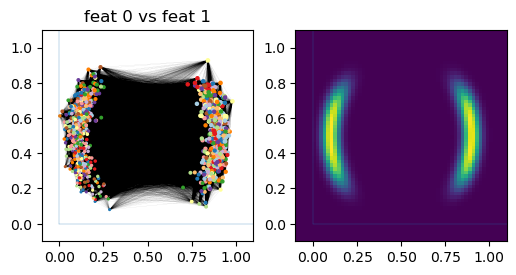

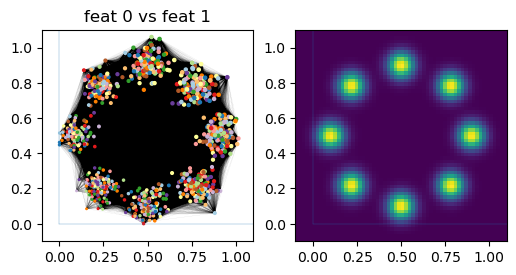

In [4]:


#* NEXT ARE DIFFERENT DEFINITIONS FOR 2 COMMUNITY GRAPHS
num_samples = 1000

# SHAPES FROM NF CLASS
# todo: import dataset 
#* two moons
graph_two_moons, dist_two_moons = sim.sample_normflows_dist(num_samples, 'TwoMoons')

# #* circular gaussian mixture
graph_circ_gaus, dist_circ_gaus = sim.sample_normflows_dist(num_samples, 'Circ')

#* two gaussians mixture
graph_two_chubs, dist_two_chubs = sim.sample_normflows_dist(num_samples, 'ChubGaus')


_, axes_moons = plt.subplots(1, 2, figsize=(6, 3))
plot_2dgraph(graph_two_moons, lorenz_fig_lims=False, x_fig_lim=[-0.1, 1.1], ax=axes_moons[0])
# plot_normflows_dist(dist_two_moons,shift=-0.5, scale=5, device=device, x_fig_lim=[-0.1, 1.1], ax=axes_moons[0])
plot_normflows_dist(dist_two_moons, lorenz=False , x_fig_lim=[-0.1, 1.1], ax=axes_moons[1])
_, axes_circ = plt.subplots(1, 2, figsize=(6, 3))
plot_2dgraph(graph_circ_gaus, lorenz_fig_lims=False, x_fig_lim=[-0.1, 1.1], ax=axes_circ[0])

plot_normflows_dist(dist_circ_gaus,lorenz=False, x_fig_lim=[-0.1, 1.1], ax=axes_circ[1])
#todo: make all of the nodes the same color




# _, axes_chubs = plt.subplots(1, 2, figsize=(6, 3))
# plot_2dgraph(graph_two_chubs, lorenz_fig_lims=False, x_fig_lim=[-0.1, 1.1], ax=axes_chubs[0])
# plot_normflows_dist(dist_two_chubs,shift=-0.5, scale=5, device=device, x_fig_lim=[-0.1, 1.1], ax=axes_chubs[0])
# plot_normflows_dist(dist_two_chubs,shift=-0.5, scale=5, device=device, x_fig_lim=[-0.1, 1.1], ax=axes_chubs[1])






### BIGCLAM

In [5]:
trainer_bigclam_twomoons = Trainer(
                model_name='bigclam',
                task=None,
                device=device,
                dataset=graph_two_moons.clone(),
                mighty_configs_dict=False
)

losses_bigclam_moons, logcut_bigclam_moons, l2_bigclam_moons = trainer_bigclam_twomoons.train(
    performance_metric= 'cut_log',
    init_feats=True,
    init_type='small_gaus',
    plot_every=-1,
    verbose=False
)

del trainer_bigclam_twomoons.data

### PCLAM

#### Two Moons

In [11]:
config_triplets = [
                    ['feat_opt', 'n_iter', 200],
                    ['feat_opt', 'lr', 0.00005],
                    ['prior_opt', 'n_iter', 150],
                    ['prior_opt', 'lr', 0.0000005],
                    ['prior_opt', 'noise_amp', 0.1],
                    ['back_forth','n_back_forth', 5],
                    ['back_forth', 'first_func_in_fit', 'fit_prior']
                ]



trainer_pclam_twomoons = Trainer(
                model_name='pclam',
                task=None,
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=graph_two_moons.clone()
)



losses_moons, logcut_moons, l2_moons = trainer_pclam_twomoons.train(
    task_params={'d' : 0.2},
    plot_every=5,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_pclam_twomoons.data
del trainer_pclam_twomoons.clamiter.prior.model

#### Circle

##### BigClam



/home/user/Documents/danny/AAAI_pieclam/tests/../trainer.py:413:::  
 starting optimization of bigclam on Circ on device cuda

 configs_dict: 
{
    "clamiter_init": {
        "dim_feat": 2,
        "dim_attr": 100,
        "s_reg": 0.0,
        "l1_reg": 0.01,
        "T": 1,
        "hidden_dim": 64,
        "num_coupling_blocks": 32,
        "num_layers_mlp": 2
    },
    "feat_opt": {
        "lr": 1e-05,
        "n_iter": 10000,
        "early_stop": 0
    }
}


/home/user/Documents/danny/AAAI_pieclam/tests/../clamiter.py:368:::  
fit wrapper fit_feats, plotting state at iter 9999


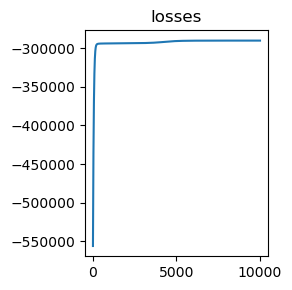



/home/user/Documents/danny/AAAI_pieclam/tests/../clamiter.py:721:::  
in plot state, calling function is fit_feats


/home/user/Documents/danny/AAAI_pieclam/tests/../utils/plotting.py:355:::  
calling_function_name= 'fit_feats' : iter 1/0


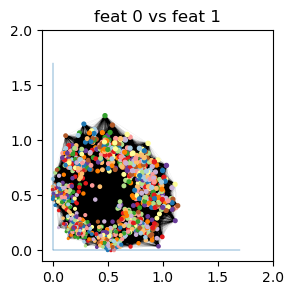

In [14]:
trainer_bigclam_circ = Trainer(
                model_name='bigclam',
                task=None,
                device=device,
                dataset=graph_circ_gaus.clone()
)

losses_bigcla_circ, logcut_bigclam_circ, l2_bigclam_circ = trainer_bigclam_circ.train(
    task_params={'d' : 0.2},
    plot_every=-1,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_bigclam_circ.data

##### pclam

In [15]:
# CIRC
config_triplets = [
                    ['feat_opt', 'n_iter', 200],
                    ['feat_opt', 'lr', 0.00003],
                    ['prior_opt', 'n_iter', 150],
                    ['prior_opt', 'lr', 0.0000005],
                    ['back_forth','n_back_forth', 5],
                    ['back_forth', 'first_func_in_fit', 'feat_opt']
                ]

trainer_pclam_circ = Trainer(
                model_name='pclam',
                task=None,
                device=device,
                config_triplets_to_change=config_triplets,
                dataset=graph_circ_gaus.clone()
)

losses_circ, logcut_circ, l2_circ = trainer_pclam_circ.train(
    task_params={'d' : 0.2},
    plot_every=5,
    init_feats=True,
    init_type='small_gaus',
    verbose=False,
    verbose_in_funcs=False
)

del trainer_pclam_circ.data
del trainer_pclam_circ.clamiter.prior.model
